In [1]:
import pandas as pd
import glob as glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
%matplotlib inline

REWARD = 1
COST = .005

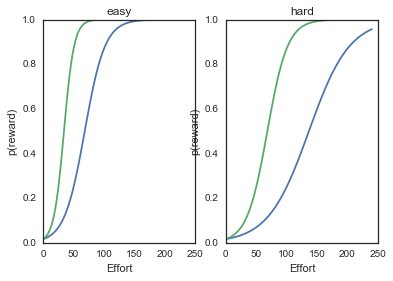

In [2]:
def prob_reward(e,diff,skill): #model for success
    #f = (e * skill) / diff #skill and effort are not independent
    b=.06 #controls slope - was .5
    a=60 #was 30
    c=0
    #a = 1
    #b = 0.05
    #c = 0
    f = (e * skill / diff) 
    
    p = 1/(1+a*np.exp(-f*b)) -c #softmax - scaling the function to be sigmoidal, small errors dont matter as much 
    
    return p

unskilled = 1
skilled = 2
easy = 1
hard = 2
es=np.linspace(0,240,100)
p0 = [prob_reward(e,easy,unskilled) for e in es]
p1 = [prob_reward(e,easy,skilled) for e in es]
plt.subplot(1,2,1)
plt.plot(es,p0, es, p1)
plt.ylim([0,1])
plt.xlabel('Effort') ; plt.ylabel('p(reward)'); plt.title('easy')


p0 = [prob_reward(e,hard,unskilled) for e in es]
p1 = [prob_reward(e,hard,skilled) for e in es]
plt.subplot(1,2,2)
plt.plot(es,p0, es, p1)
plt.ylim([0,1])
plt.xlabel('Effort') ; plt.ylabel('p(reward)'); plt.title('hard')

### Create utility function
 Utility = R x P(R|E,S,D)-cost x E

In [3]:
def get_effort(reward, cost, diff, skill):  #model for planning. Takes in diff, skill, and cost -returns effort
    Us=list()
    es = np.linspace(0, 100, 100) #used to be (0,200,100)
    for i in es:
        U=reward*prob_reward(i, diff, skill)-cost*i #utility function
        Us.append(U)
    return es[np.argmax(Us)], Us, es  #return argmax of utility, and utilities 
            

Let's plot a few different optimal utilities

* keept effort from 1-100
* cost = .17
* reward =30

For our four conditions, here are some values that we used
* High difficulty, high skill: diff = 100, skill = 100
* High difficulty, low skill: diff = 100, skill = 50
* Low difficulty, high skill: diff = 50, skill = 100
* Low difficulty, low skill: diff = 50, skill = 50

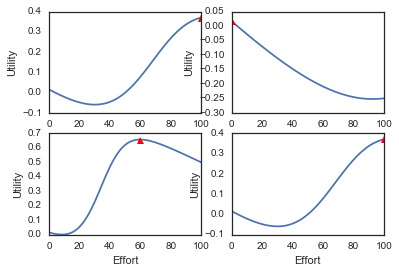

In [4]:

plt.subplot(2,2,1)
effort,Us,es=get_effort(REWARD,COST,hard,skilled) 
plt.plot(es,Us)
plt.plot(effort,max(Us),'r^')
plt.xlabel('Effort')
plt.ylabel('Utility')

plt.subplot(2,2,2)
effort,Us,es=get_effort(REWARD,COST,hard,unskilled) 
plt.plot(es,Us)
plt.plot(effort,max(Us),'r^')
plt.xlabel('Effort')
plt.ylabel('Utility')

plt.subplot(2,2,3)
effort,Us,es=get_effort(REWARD,COST,easy,skilled) 
plt.plot(es,Us)
plt.plot(effort,max(Us),'r^')
plt.xlabel('Effort')
plt.ylabel('Utility')

plt.subplot(2,2,4)
effort,Us,es=get_effort(REWARD,COST,easy,unskilled) 
plt.plot(es,Us)
plt.plot(effort,max(Us),'r^')
plt.xlabel('Effort')
plt.ylabel('Utility')
#plt.savefig('/Users/julialeonard/Desktop/Fall 2015/CoCoSci/final project/imgs/lowD_lowS.pdf')


### Build forward model with uncertainty
#### Chances of success and effort given skill, diff, reward, cost

Goal: create utility values for each value of effort given four conditions of skill and difficulty
* sample 10,000 difficulties from  beta(.3, .3)*100 distribution (best captures that toy was either hard or easy) and 10,000 skills from beta (5,3) distribution (captures that adults are more skilled than kids)
* cost = .17 (arbitrary value)
* reward =30 (arbitrary value)
* To build these posteriors, we sampled from our distributions of skill and difficulty, and if, for example, success= true (set as > .75 here) and effort = high (set at >70 here), we saved those values of difficulty and skill into posteriors for the condition ‘high effort success’ 



In [5]:
threshold = 70
#MAKE INTO DIC
sampled_skill_high = list()
sampled_diff_high = list()
sampled_skill_low = list()
sampled_diff_low = list()
sampled_skill_low_fail=list()
sampled_diff_low_fail=list()
sampled_skill_high_fail=list()
sampled_diff_high_fail=list()
diff_samp=list()
skill_samp=list()
effort_samp=list()
succes_samp=list()
for _ in xrange(10000):
    skill = np.random.beta(5,3)*100 #skill is a beta function
    #diff = np.random.uniform(1,30)
    diff = np.random.beta(.3,.3)*100 #difficulty is a beta function
    effort,_,_= get_effort(REWARD, COST, diff, skill)
    high_effort = effort>threshold
    low_effort=effort<threshold
    num=np.random.random()
#     num = .75
    success=prob_reward(effort,diff,skill)>num #output values where high effort and success are true
    fail=prob_reward(effort,diff,skill)<num

    # trying to take out parameter of num
    
    diff_samp.append(diff)
    skill_samp.append(skill)
    effort_samp.append(effort)
    succes_samp.append(success)
    if success and high_effort: 
        sampled_skill_high.append(skill)
        sampled_diff_high.append(diff)
    elif success and low_effort: 
        sampled_skill_low.append(skill)
        sampled_diff_low.append(diff)
    elif fail and low_effort: 
        sampled_skill_low_fail.append(skill)
        sampled_diff_low_fail.append(diff)
    elif fail and high_effort: 
        sampled_skill_high_fail.append(skill)
        sampled_diff_high_fail.append(diff)
        

In [6]:
#export values into dataframe for R
d=np.array(diff_samp)
s=np.array(skill_samp)
e=np.array(effort_samp)
suc=np.array(succes_samp)
d=np.vstack([d, s, e, suc])
d=pd.DataFrame(data=d)
d=d.transpose()
d.columns = ['diff', 'skill','effort','success']
#d.to_csv('/Users/julialeonard/Desktop/posteriors.csv')

Let's plot some posteriors in different conditions

* sampled_skill_high
* sampled_diff_high 
* sampled_skill_low
* sampled_diff_low 
* sampled_skill_low_fail
* sampled_diff_low_fail
* sampled_skill_high_fail
* sampled_diff_high_fail

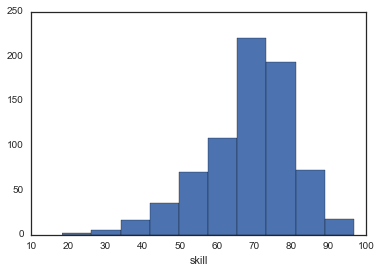

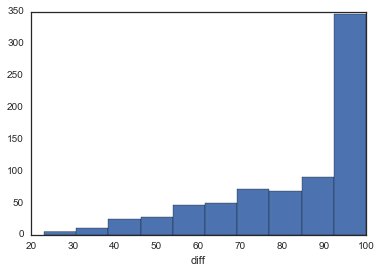

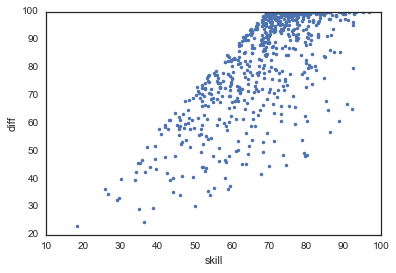

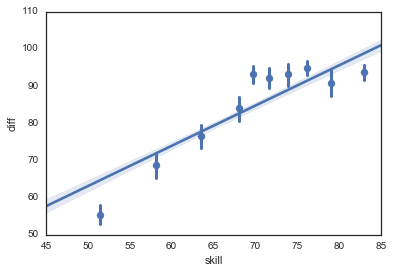

In [7]:
sampled_skill=sampled_skill_high_fail
sampled_diff=sampled_diff_high_fail
plt.hist(sampled_skill)
plt.xlabel('skill')
plt.figure()
plt.hist(sampled_diff)
plt.xlabel('diff')
plt.figure()
plt.plot(sampled_skill,sampled_diff,".")
plt.xlabel('skill')
plt.ylabel('diff')
plt.figure()
sns.regplot(np.array(sampled_skill), np.array(sampled_diff), x_bins=10)
plt.xlabel('skill')
plt.ylabel('diff')
plt.show()

(0, 100)

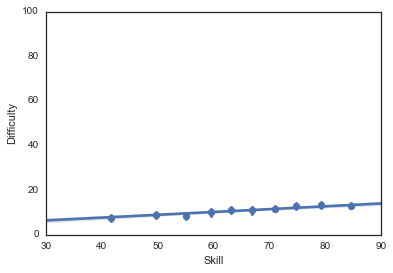

In [8]:
sampled_skill=sampled_skill_low
sampled_diff=sampled_diff_low
sns.regplot(np.array(sampled_skill), np.array(sampled_diff), x_bins=10)
plt.xlabel('Skill')
plt.ylabel('Difficulty')
plt.ylim([0,100])
#plt.show()
#plt.savefig('/Users/julialeonard/Desktop/Fall 2015/CoCoSci/final project/imgs/lowE_success.pdf')


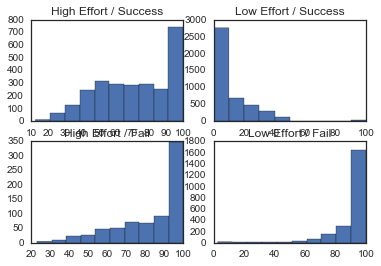

In [10]:
plt.subplot(2,2,1)
plt.hist(sampled_diff_high)
plt.title('High Effort / Success')
plt.subplot(2,2,2)
plt.hist(sampled_diff_low)
plt.title('Low Effort / Success')
plt.subplot(2,2,3)
plt.hist(sampled_diff_high_fail)
plt.title('High Effort / Fail')
plt.subplot(2,2,4)
plt.hist(sampled_diff_low_fail)
plt.title('Low Effort / Fail')


# sampled_skill=sampled_skill_high
# sampled_diff=sampled_diff_high
# # plt.figure(figsize=(4, 3))
# sns.jointplot(
#     np.array(sampled_skill), np.array(sampled_diff),
#     kind="scatter",stat_func=None).set_axis_labels("Skill", "Difficulty")
# plt.ylim([0,100])
# plt.xlim([0,100])
# sns.set_context('paper',font_scale=2)
#plt.savefig('/Users/julialeonard/Desktop/highE_succ.pdf')

### Create function for child's effort from adult effort

* take difficulty posteriors for each condition and plug them into ‘optimal effort/ Utility’ function
* sample 10,000 times from beta(3,5)*100 distribution (kids are less skilled than adults) and randomly picked difficulties from posterioes per each condition to get output of optimal effort per skill per condition.


In [27]:
def get_your_effort(reward, cost, diff):  #model for planning. Takes in diff, skill, and cost -returns effort
    sampled_effort= list()
    sampled_skill=list()
    for i in xrange(10000):
        s = np.random.beta(3,5)*100
        d = np.random.choice(diff)
        effort,_,_=get_effort(reward, cost, d, s)
        sampled_effort.append(effort)
        sampled_skill.append(s)
    
    return sampled_effort, sampled_skill

In [28]:
diff = np.random.beta(.3,.3,size=10000)*100
effort_baseline,skill_baseline = get_your_effort(REWARD,COST,diff)



(0, 100)

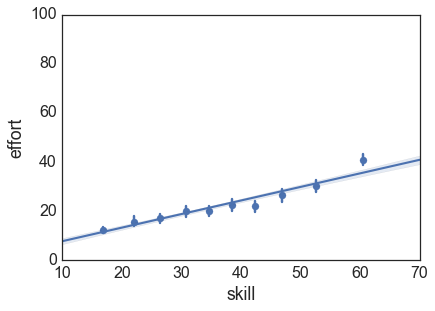

In [29]:
plt.figure()
sns.regplot(np.array(skill_baseline), np.array(effort_baseline), x_bins=10)
plt.xlabel('skill')
plt.ylabel('effort')
plt.ylim([0,100])

In [30]:

diff =  sampled_diff_high
effort_high_success,skill_high_success = get_your_effort(REWARD,COST,diff) #used to be c=.1
diff =  sampled_diff_low
effort_low_success,skill_low_success = get_your_effort(REWARD,COST,diff) #used to be c=.1
diff =  sampled_diff_high_fail
effort_high_fail,skill_high_fail = get_your_effort(REWARD,COST,diff) #used to be c=.1
diff =  sampled_diff_low_fail
effort_low_fail,skill_low_fail = get_your_effort(REWARD,COST,diff) #used to be c=.1



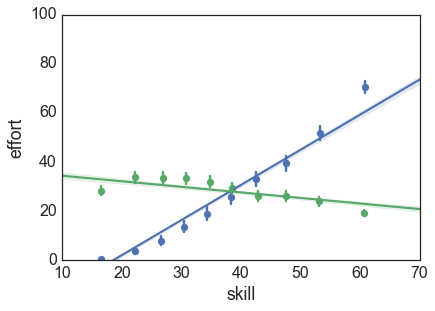

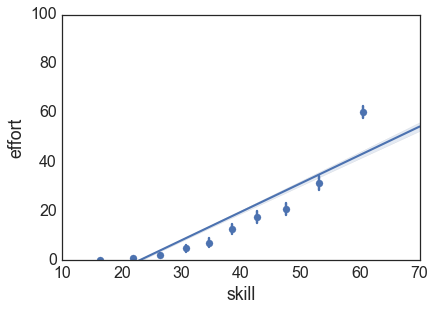

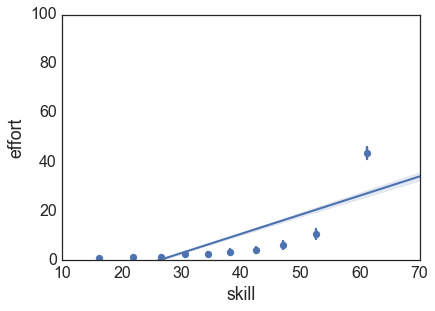

In [31]:
sns.regplot(np.array(skill_high_success), np.array(effort_high_success), x_bins=10)
plt.xlabel('skill')
plt.ylabel('effort')
plt.ylim([0,100])

#plt.savefig('/Users/julialeonard/Desktop/Fall 2015/CoCoSci/final project/imgs/highE_success.pdf')
#plt.figure()
sns.regplot(np.array(skill_low_success), np.array(effort_low_success), x_bins=10)
plt.xlabel('skill')
plt.ylabel('effort')
plt.ylim([0,100])
#plt.savefig('/Users/julialeonard/Desktop/Fall 2015/CoCoSci/final project/imgs/LowE_highE_success.pdf')
plt.figure()
sns.regplot(np.array(skill_high_fail), np.array(effort_high_fail), x_bins=10)
plt.xlabel('skill')
plt.ylabel('effort')
plt.ylim([0,100])
#plt.savefig('/Users/julialeonard/Desktop/Fall 2015/CoCoSci/final project/imgs/HighE_fail.pdf')
plt.figure()
sns.regplot(np.array(skill_low_fail), np.array(effort_low_fail), x_bins=10)
plt.xlabel('skill')
plt.ylabel('effort')
plt.ylim([0,100])
#plt.savefig('/Users/julialeonard/Desktop/Fall 2015/CoCoSci/final project/imgs/LowE_fail.pdf')

plt.show()

(10, 70)

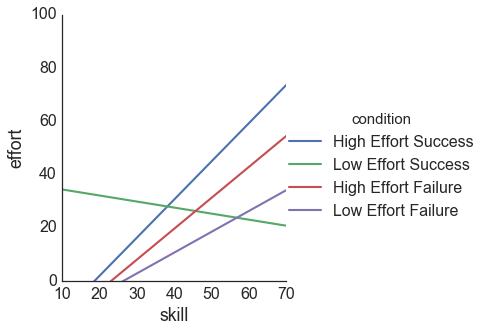

In [32]:
df = []
for s, e in zip(skill_high_success, effort_high_success):
    df.append({
            'skill':s,
            'effort':e,
            'condition':'High Effort Success'
        })

for s, e in zip(skill_low_success, effort_low_success):
    df.append({
            'skill':s,
            'effort':e,
            'condition':'Low Effort Success'
        })
    
for s, e in zip(skill_high_fail, effort_high_fail):
    df.append({
            'skill':s,
            'effort':e,
            'condition':'High Effort Failure'
        })
    
for s, e in zip(skill_low_fail, effort_low_fail):
    df.append({
            'skill':s,
            'effort':e,
            'condition':'Low Effort Failure'
        })
    
df = pd.DataFrame(df)

sns.lmplot(x="skill", y="effort", hue="condition", data=df, scatter=False, ci=None)
plt.ylim([0,100])
plt.xlim([10,70])

### Fit model to child data

If we make the assumption that children perceive themselves as around less than half as skilled as a very skilled adult (~100 for adult, ~47 for child), then we can compare the model mean predictions (multiplied by 3 to fit the scale of the child data) to the mean effort time in the child data 

In [33]:
def your_eff_know_skill(reward, cost, diff,skill):  #model for planning. Takes in diff, skill, and cost -returns effort
    sampled_effort= list()
    sampled_skill=list()
    for i in xrange(10000):
        d = np.random.choice(diff)
        effort,_,_=get_effort(reward, cost, d, skill)
        sampled_effort.append(effort)
        sampled_skill.append(skill)
    
    return sampled_effort

In [34]:
skill=47
your_eff_know_skill(REWARD, COST, diff,skill)
diff =  sampled_diff_high
effort_high_success = your_eff_know_skill(REWARD, COST, diff,skill) #used to be c=.1
diff =  sampled_diff_low
effort_low_success = your_eff_know_skill(REWARD, COST, diff,skill) #used to be c=.1
diff =  sampled_diff_high_fail
effort_high_fail = your_eff_know_skill(REWARD, COST, diff,skill) #used to be c=.1
diff =  sampled_diff_low_fail
effort_low_fail = your_eff_know_skill(REWARD, COST, diff,skill) #used to be c=.1


print np.mean(effort_high_success)
print np.mean(effort_low_success)
print np.mean(effort_high_fail)
print np.mean(effort_low_fail)


39.9650505051
25.5176767677
20.5453535354
6.08797979798


In [35]:
scale = 2.5
print np.mean(effort_high_success)*scale
print np.mean(effort_low_success)*scale
print np.mean(effort_high_fail)*scale
print np.mean(effort_low_fail)*scale

high_effort_fail=30
high_effort_success=107
low_effort_fail=35
low_effort_success=57

d = {'Model' : pd.Series([np.mean(effort_high_success)*scale, np.mean(effort_low_success)*scale, np.mean(effort_high_fail)*scale, np.mean(effort_low_fail)*scale], index=['High Effort Success', 'Low Effort Success', 'High Effort Failure', 'Low Effort Failure']),
     'Human' : pd.Series([107, 57, 30, 35], index=['High Effort Success', 'Low Effort Success', 'High Effort Failure', 'Low Effort Failure'])}

df = pd.DataFrame(d)
df


99.9126262626
63.7941919192
51.3633838384
15.2199494949


,Human,Model
High Effort Success,107,99.912626
Low Effort Success,57,63.794192
High Effort Failure,30,51.363384
Low Effort Failure,35,15.219949
